In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    residual_block = convolution_input

    if(should_pool):
        residual_block = MaxPooling1D(pool_size=2, strides=2, padding='same')(residual_block)

    residual_block = convolution_block(
        residual_block, residual_convolution_options)
    residual_block = convolution_block(
        residual_block, residual_convolution_options)

    convolution_output = add([residual_block, convolution_input])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)

custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = residual_block(averaged_embedding_layer, should_pool = False)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21440/102124 [=====>........................] - ETA: 6:00 - loss: 0.1148 - acc: 0.9611

102112/102124 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9743

102124/102124 [==============================] - 478s 5ms/step - loss: 0.0742 - acc: 0.9743 - val_loss: 0.0603 - val_acc: 0.9760
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 6:26 - loss: 0.0547 - acc: 0.9798

102112/102124 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9797

102124/102124 [==============================] - 477s 5ms/step - loss: 0.0552 - acc: 0.9797 - val_loss: 0.0460 - val_acc: 0.9823
roc-auc: 0.9833 - roc-auc_val: 0.9804                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 6:39 - loss: 0.0534 - acc: 0.9799

102112/102124 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9808

102124/102124 [==============================] - 473s 5ms/step - loss: 0.0516 - acc: 0.9808 - val_loss: 0.0478 - val_acc: 0.9814
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 6:33 - loss: 0.0500 - acc: 0.9811

102112/102124 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9815

102124/102124 [==============================] - 474s 5ms/step - loss: 0.0491 - acc: 0.9815 - val_loss: 0.0447 - val_acc: 0.9826
roc-auc: 0.989 - roc-auc_val: 0.9863                                                                                                    
Epoch 5/32
  8768/102124 [=>............................] - ETA: 6:38 - loss: 0.0465 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9822

102124/102124 [==============================] - 468s 5ms/step - loss: 0.0471 - acc: 0.9822 - val_loss: 0.0469 - val_acc: 0.9814
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 6:16 - loss: 0.0457 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9825

102124/102124 [==============================] - 468s 5ms/step - loss: 0.0459 - acc: 0.9825 - val_loss: 0.0418 - val_acc: 0.9835
roc-auc: 0.9903 - roc-auc_val: 0.987                                                                                                    
Epoch 7/32
  8768/102124 [=>............................] - ETA: 6:39 - loss: 0.0453 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9827

102124/102124 [==============================] - 469s 5ms/step - loss: 0.0449 - acc: 0.9827 - val_loss: 0.0428 - val_acc: 0.9832
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 6:16 - loss: 0.0455 - acc: 0.9819

102112/102124 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9829

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0437 - acc: 0.9829 - val_loss: 0.0414 - val_acc: 0.9839
roc-auc: 0.9914 - roc-auc_val: 0.9875                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 6:39 - loss: 0.0420 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9832

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0431 - acc: 0.9832 - val_loss: 0.0409 - val_acc: 0.9840
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 6:16 - loss: 0.0424 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9835

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0427 - acc: 0.9835 - val_loss: 0.0436 - val_acc: 0.9826
roc-auc: 0.9921 - roc-auc_val: 0.9881                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 6:40 - loss: 0.0430 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0419 - acc: 0.9836 - val_loss: 0.0421 - val_acc: 0.9833

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/32
  8032/102124 [=>............................] - ETA: 6:43 - loss: 0.0403 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9840

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0409 - acc: 0.9840 - val_loss: 0.0433 - val_acc: 0.9823
roc-auc: 0.9926 - roc-auc_val: 0.988                                                                                                    
Epoch 13/32
  8736/102124 [=>............................] - ETA: 6:41 - loss: 0.0386 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9842

102124/102124 [==============================] - 471s 5ms/step - loss: 0.0406 - acc: 0.9842 - val_loss: 0.0410 - val_acc: 0.9838
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 6:16 - loss: 0.0399 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.0409 - val_acc: 0.9838
roc-auc: 0.9931 - roc-auc_val: 0.9882                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 6:40 - loss: 0.0397 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9845

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0396 - acc: 0.9845 - val_loss: 0.0406 - val_acc: 0.9840
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 6:17 - loss: 0.0385 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9846

102124/102124 [==============================] - 470s 5ms/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0403 - val_acc: 0.9842
roc-auc: 0.9936 - roc-auc_val: 0.9883                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 6:40 - loss: 0.0384 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9846

102124/102124 [==============================] - 469s 5ms/step - loss: 0.0386 - acc: 0.9846 - val_loss: 0.0402 - val_acc: 0.9842
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 6:15 - loss: 0.0372 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9847

102124/102124 [==============================] - 469s 5ms/step - loss: 0.0385 - acc: 0.9847 - val_loss: 0.0406 - val_acc: 0.9840
roc-auc: 0.994 - roc-auc_val: 0.9884                                                                                                    
Epoch 19/32
  8736/102124 [=>............................] - ETA: 6:39 - loss: 0.0379 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9848

102124/102124 [==============================] - 469s 5ms/step - loss: 0.0382 - acc: 0.9848 - val_loss: 0.0406 - val_acc: 0.9838
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 6:15 - loss: 0.0400 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9851

102124/102124 [==============================] - 469s 5ms/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0407 - val_acc: 0.9840
roc-auc: 0.9942 - roc-auc_val: 0.9882                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 7:02 - loss: 0.0363 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9852

102124/102124 [==============================] - 477s 5ms/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0402 - val_acc: 0.9842
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 6:23 - loss: 0.0367 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9852

102124/102124 [==============================] - 477s 5ms/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0406 - val_acc: 0.9841

Epoch 00022: ReduceLROnPlateau reducing learning rate to 5.632815373246558e-05.
roc-auc: 0.9946 - roc-auc_val: 0.9882                                                                                                    
Epoch 23/32
  5952/102124 [>.............................] - ETA: 7:02 - loss: 0.0396 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9851

102124/102124 [==============================] - 477s 5ms/step - loss: 0.0371 - acc: 0.9851 - val_loss: 0.0409 - val_acc: 0.9839
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 6:16 - loss: 0.0369 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9852

102124/102124 [==============================] - 475s 5ms/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0409 - val_acc: 0.9839
roc-auc: 0.9947 - roc-auc_val: 0.9883                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 6:52 - loss: 0.0388 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9854

102124/102124 [==============================] - 477s 5ms/step - loss: 0.0364 - acc: 0.9854 - val_loss: 0.0407 - val_acc: 0.9839
Epoch 26/32
 13984/102124 [===>..........................] - ETA: 6:21 - loss: 0.0367 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9855

102124/102124 [==============================] - 476s 5ms/step - loss: 0.0362 - acc: 0.9855 - val_loss: 0.0403 - val_acc: 0.9842
roc-auc: 0.995 - roc-auc_val: 0.9881                                                                                                    
Epoch 27/32
  8736/102124 [=>............................] - ETA: 6:51 - loss: 0.0377 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9855

102124/102124 [==============================] - 478s 5ms/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0411 - val_acc: 0.9835


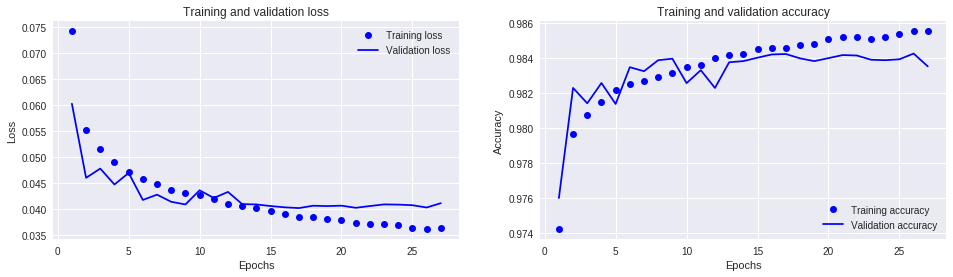

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 45s 1ms/step
([0.03993729107605987, 0.9839991516423005], 0.9900751531246609)


In [13]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42880/102124 [===========>..................] - ETA: 4:01 - loss: 0.1062 - acc: 0.9645

102124/102124 [==============================] - 444s 4ms/step - loss: 0.0804 - acc: 0.9724 - val_loss: 0.0624 - val_acc: 0.9749
Epoch 2/32
  5440/102124 [>.............................] - ETA: 6:25 - loss: 0.0584 - acc: 0.9791

102080/102124 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9799

102124/102124 [==============================] - 439s 4ms/step - loss: 0.0552 - acc: 0.9799 - val_loss: 0.0500 - val_acc: 0.9801
roc-auc: 0.9825 - roc-auc_val: 0.9787                                                                                                    
Epoch 3/32
 17408/102124 [====>.........................] - ETA: 5:38 - loss: 0.0508 - acc: 0.9811

102080/102124 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9808

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0514 - acc: 0.9808 - val_loss: 0.0433 - val_acc: 0.9835
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 5:26 - loss: 0.0482 - acc: 0.9821

102080/102124 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9816

102124/102124 [==============================] - 439s 4ms/step - loss: 0.0489 - acc: 0.9816 - val_loss: 0.0466 - val_acc: 0.9817
roc-auc: 0.9884 - roc-auc_val: 0.9848                                                                                                    
Epoch 5/32
 17408/102124 [====>.........................] - ETA: 5:38 - loss: 0.0471 - acc: 0.9819

102080/102124 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9818

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0474 - acc: 0.9818 - val_loss: 0.0497 - val_acc: 0.9801

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
 16064/102124 [===>..........................] - ETA: 5:44 - loss: 0.0449 - acc: 0.9827

102080/102124 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9825

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0457 - acc: 0.9825 - val_loss: 0.0432 - val_acc: 0.9831
roc-auc: 0.9904 - roc-auc_val: 0.9869                                                                                                    
Epoch 7/32
 17408/102124 [====>.........................] - ETA: 5:38 - loss: 0.0455 - acc: 0.9822

102080/102124 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9826

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0446 - acc: 0.9826 - val_loss: 0.0458 - val_acc: 0.9818
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 5:26 - loss: 0.0439 - acc: 0.9829

102080/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9831

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0438 - acc: 0.9831 - val_loss: 0.0432 - val_acc: 0.9828
roc-auc: 0.9908 - roc-auc_val: 0.9861                                                                                                    
Epoch 9/32
 17408/102124 [====>.........................] - ETA: 5:39 - loss: 0.0425 - acc: 0.9835

102080/102124 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9833

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0429 - acc: 0.9832 - val_loss: 0.0450 - val_acc: 0.9817
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 5:26 - loss: 0.0418 - acc: 0.9836

102080/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 440s 4ms/step - loss: 0.0419 - acc: 0.9836 - val_loss: 0.0414 - val_acc: 0.9835
roc-auc: 0.9925 - roc-auc_val: 0.988                                                                                                    
Epoch 11/32
 17408/102124 [====>.........................] - ETA: 5:37 - loss: 0.0397 - acc: 0.9844

102080/102124 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9838

102124/102124 [==============================] - 439s 4ms/step - loss: 0.0413 - acc: 0.9838 - val_loss: 0.0435 - val_acc: 0.9824
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 5:25 - loss: 0.0402 - acc: 0.9842

102080/102124 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9840

102124/102124 [==============================] - 437s 4ms/step - loss: 0.0407 - acc: 0.9840 - val_loss: 0.0445 - val_acc: 0.9822
roc-auc: 0.9928 - roc-auc_val: 0.9879                                                                                                    
Epoch 13/32
 17344/102124 [====>.........................] - ETA: 5:36 - loss: 0.0405 - acc: 0.9836

102080/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9844

102124/102124 [==============================] - 438s 4ms/step - loss: 0.0397 - acc: 0.9844 - val_loss: 0.0420 - val_acc: 0.9834
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 5:26 - loss: 0.0391 - acc: 0.9844

102080/102124 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9844

102124/102124 [==============================] - 438s 4ms/step - loss: 0.0393 - acc: 0.9844 - val_loss: 0.0412 - val_acc: 0.9837
roc-auc: 0.9936 - roc-auc_val: 0.9878                                                                                                    
Epoch 15/32
 17344/102124 [====>.........................] - ETA: 5:36 - loss: 0.0373 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9845

102124/102124 [==============================] - 437s 4ms/step - loss: 0.0389 - acc: 0.9845 - val_loss: 0.0429 - val_acc: 0.9827
Epoch 16/32
 20288/102124 [====>.........................] - ETA: 5:24 - loss: 0.0388 - acc: 0.9848

102080/102124 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9848

102124/102124 [==============================] - 438s 4ms/step - loss: 0.0384 - acc: 0.9848 - val_loss: 0.0425 - val_acc: 0.9830

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010511204891372472.
roc-auc: 0.9941 - roc-auc_val: 0.9883                                                                                                    
Epoch 17/32
 11840/102124 [==>...........................] - ETA: 5:58 - loss: 0.0372 - acc: 0.9853

102080/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9851

102124/102124 [==============================] - 437s 4ms/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0423 - val_acc: 0.9830
Epoch 18/32
 20288/102124 [====>.........................] - ETA: 5:24 - loss: 0.0367 - acc: 0.9855

102080/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9852

102124/102124 [==============================] - 438s 4ms/step - loss: 0.0373 - acc: 0.9852 - val_loss: 0.0429 - val_acc: 0.9830
roc-auc: 0.9945 - roc-auc_val: 0.9881                                                                                                    
Epoch 19/32
 17344/102124 [====>.........................] - ETA: 5:37 - loss: 0.0369 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9852

102124/102124 [==============================] - 438s 4ms/step - loss: 0.0370 - acc: 0.9852 - val_loss: 0.0435 - val_acc: 0.9826
Epoch 20/32
 20288/102124 [====>.........................] - ETA: 5:25 - loss: 0.0363 - acc: 0.9856

102080/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9853

102124/102124 [==============================] - 443s 4ms/step - loss: 0.0370 - acc: 0.9853 - val_loss: 0.0413 - val_acc: 0.9835
roc-auc: 0.9949 - roc-auc_val: 0.9879                                                                                                    
Epoch 21/32
 17344/102124 [====>.........................] - ETA: 5:37 - loss: 0.0363 - acc: 0.9852

102080/102124 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9854

102124/102124 [==============================] - 442s 4ms/step - loss: 0.0364 - acc: 0.9854 - val_loss: 0.0434 - val_acc: 0.9827
Epoch 22/32
 20288/102124 [====>.........................] - ETA: 5:33 - loss: 0.0351 - acc: 0.9864

102080/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9855

102124/102124 [==============================] - 444s 4ms/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0420 - val_acc: 0.9833
roc-auc: 0.9951 - roc-auc_val: 0.9883                                                                                                    
Epoch 23/32
 17344/102124 [====>.........................] - ETA: 5:37 - loss: 0.0362 - acc: 0.9855

102080/102124 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9858

102124/102124 [==============================] - 443s 4ms/step - loss: 0.0356 - acc: 0.9858 - val_loss: 0.0413 - val_acc: 0.9839
Epoch 24/32
 20288/102124 [====>.........................] - ETA: 5:32 - loss: 0.0343 - acc: 0.9861

102080/102124 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9856

102124/102124 [==============================] - 444s 4ms/step - loss: 0.0359 - acc: 0.9856 - val_loss: 0.0420 - val_acc: 0.9833
roc-auc: 0.9953 - roc-auc_val: 0.9878                                                                                                    


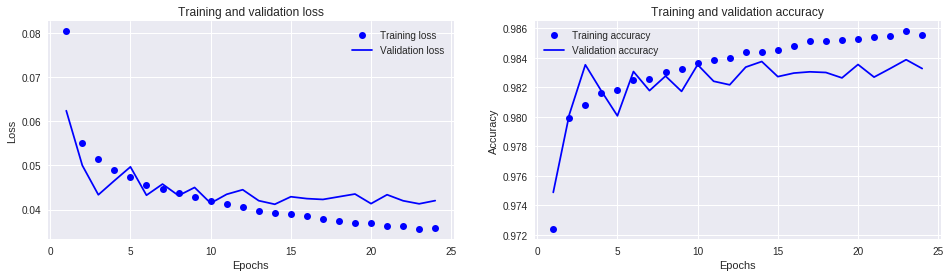

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 43s 1ms/step
([0.040650894860782986, 0.9837798176057545], 0.9896891111776719)
